# Galaxy SED Fitting

SED fitting is the primary method by which astronomers extract physical properties from galaxy SEDs. At its core, this process involves comparing observed spectra/photometry to a suite of modeled spectra/photometry to infer a galaxy's mass, age, metallicity, redshift, etc. In this notebook, I demonstrate the very basics of galaxy SED fitting utilizing chi-squared minimization over a grid of galaxy masses and ages.

## Generate grid of model SSP SEDs

Our first step is to load in the models that we'll be comparing (fitting) our data to. For this purpose, I chose to use models from the Binary Population and Spectral Synthesis (BPASS) code (Eldridge et al. 2017). For the sake of memory usage and clarity in illustrating the fundamentals of SED fitting, I use only one grid of simple stellar population (SSP) SEDs with varying ages at a fixed metallicity (solar) assuming a Chabrier IMF.

The template set is encoded in a single ascii file which contains a wavelength column spanning 1-100,000 Angstroms and 51 model SED columns, each corresponding to an age between $10^6$ and $10^{11}$ yr in 0.1 dex intervals. Note that the quoted fluxes are in solar luminosities from a population of $10^6$ $M_{\odot}$. We'll convert this to more standard flux units and normalize to $1\,M_{\odot}$ later on.

In [1]:
import numpy as np

# Load in SSP templates
seds = np.loadtxt('CWhite_files/spectra-bin-imf_chab100.z020.dat')

You'll notice that it took quite a while to load in this set of templates. This is because the SEDs are sampled at 100,000 wavelength points for each of the 51 ages! This kind of resolution is relatively common from population synthesis models; however, most users will be fitting to broadband photometry over a subset of these wavelengths. So to cut down on the runtime and memory usage without sacrificing significant information from the models, we can interpolate our models to coarses wavelength bins!

In [2]:
seds.shape

(100000, 52)

In [3]:
# Extract template wavelengths
wl = seds[:,0]

# Define smaller set of wavelengths to conserve memory
wl_interp = np.arange(2000,30000,10)
logAges = np.arange(6,11.1,0.1)
grid = np.zeros((wl_interp.size,logAges.size))
for i in range(logAges.size):
    sed = seds[:,i]
    sed_interp = np.interp(wl_interp,wl,sed)
    grid[:,i] = sed_interp

# Convert fluxes to erg/s/Ang per solar mass of stars
grid *= 1e-6 * 3.826e33

## Create mock HST photometry

We have our models, but now we need data to compare to! To generate these data, I'll simply simulate some photometry from one of the models I've already loaded in. How about we simulate Hubble observations of a 100 Myr old population with a mass of $10^9\,M_{\odot}$ located 1 Mpc away? To do this, let's pick out the BPASS SED corresponding to an age of $10^8$ yr, scale it to a mass of $10^9\,M_{\odot}$, and convolve it with our filter set. Finally, we'll add some noise to these data (assuming 10$\sigma$ detections in each band) so that we're not just fitting the model to itself!

In [4]:
from astropy.io import fits

# Load in filter catalog. This catalog has throughput information for many different filters and many different
# telescopes. We'll just pick out eight bands from the ACS and WFC3 instruments on HST spanning the near-UV to 
# near-IR and ignore the rest.
filtCat = fits.open('CWhite_files/filt_master.fits')[1].data

# Specify which filters we want to extract from our filter catalog
acs = ['ACS_'+filt for filt in ['F435W','F606W','F814W','F850LP']] 
wfc3 = ['WFC3_'+filt for filt in ['F336W','F105W','F125W','F160W']]
filtNames = acs + wfc3

# Store (wavelength,throughput) data into a dictionary.
filtDict = {}
for filt in filtNames:
    filtDict[filt] = filtCat[filt][0]

In [5]:
# Generate mock photometry from 100 Myr SSP 1 Mpc away assuming 10-sigma detections in all bands

# Define distance and stellar mass
d = 3.086e24 # cm
M = 1e9 # solar masses

# Extract our chosen model, scale to 1e9 Msol and calculate flux at 1 Mpc
model = grid[:,20] * M / (4 * np.pi * d**2) # erg/s/cm^2/A

# Initialize empty dictionary where we'll store the "observed" photometry
obsData = {}
obsData['wl'] = np.zeros(len(filtNames))
obsData['flux'] = np.zeros(len(filtNames))
obsData['eflux'] = np.zeros(len(filtNames))

# Loop over filter set to calculate flux in each band
for i,filt in enumerate(filtNames):
    
    # Extract filter wavelengths and throughput data
    lam = filtDict[filt][0]
    thpt = filtDict[filt][1]
    
    # interpolate model SED to filter wavelengths
    model_interp = np.interp(lam,wl_interp,model)
    
    # Convolve model through filter
    flux = np.trapz(thpt*model_interp,x=lam) / np.trapz(thpt,x=lam)
    
    # Add Gaussian noise assuming a 10-sigma detection
    fluxErr = flux/10.
    flux = np.random.normal(flux, scale = fluxErr)
    
    # Store flux info in dictionary
    obsData['flux'][i] = flux
    obsData['eflux'][i] = fluxErr
    
    # Calculate filter effective wavelength and store in dictionary
    wlEff = np.trapz(lam*thpt,x=lam) / np.trapz(thpt,x=lam)
    obsData['wl'][i] = wlEff

Great, now we have a simulated dataset! Let's plot our photometry to see how it compares to the model we generated it from...

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

# Generate figure
fig = plt.figure(figsize=(2*6.4,1.1*4.8))
plt.xscale('log')
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux Density [erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]')

# Plot model SED
plt.plot(wl_interp, model, c='grey', zorder=0)

# Plot simulated photometry
plt.errorbar(obsData['wl'], obsData['flux'], yerr=obsData['eflux'], fmt='o', mfc='dodgerblue', mec='navy', ecolor='navy', capsize=8, capthick=2, ms=10)

# Plot filter throughput curves
ymin,ymax = model.min(),model.max()
for filt in filtNames:
    filtWl = filtDict[filt][0]
    filtTh = filtDict[filt][1]
    filtTh /= filtTh.max()
    filtTh = 10**(0.2*(np.log10(ymax/ymin))+1)*filtTh * ymin
    plt.plot(filtWl,filtTh)
    
plt.ylim(ymin=0)

plt.show()

<Figure size 1280x528 with 1 Axes>

# Iterative $\chi^2$ Fit

We finally have a dataset and a suite of models to compare it to! In particular, we want to recover the age and mass of the observed stellar population, so these are our two free parameters. To accomplish this, we'll opt for a simple chi-square fit, i.e., we want to minimize the sum of the square differences between each model and our data (normalized by the uncertainties in our data).

The first step of this procedure is determining the (uniform) priors on mass and age. Let's adopt $[10^5,10^{11}]$ $M_{\odot}$ and $[10^6,10^{11}]$ yr (set by the age range of BPASS) for the mass and age ranges, respectively. Then, for each (mass,age) combination, we calculate photometry for that model for our filter set. Finally, we calculate chi-squared as,

$$\chi^2=\sum\left(\frac{\mathrm{Data}-\mathrm{Model}}{\mathrm{Error}}\right)^2, $$

and pick out the (mass,age) combination that minimizes $\chi^2$!

In [7]:
# Define age/mass ranges
logMasses = np.arange(5,11.1,0.1)
ageCols = np.arange(logAges.size) # this indexes the columns corresponding to a given age

# Initialize minimized chi-squared as equal to infinity (we'll iteratively redefine this later)
leastChisq = np.inf

# Loop over parameter combinations
for logMass in logMasses:
    
    for j in ageCols:
        
        # Scale model to currently-tested stellar mass and convert to flux units at 1 Mpc
        mass = 10**logMass        
        model = grid[:,j] * mass / (4 * np.pi * d**2) # erg/s/cm2/a
        
        # Generate photometry of model in our HST filter set
        modelFluxes = np.zeros(len(filtNames))
        for i,filt in enumerate(filtNames):
                 
            lam = filtDict[filt][0]
            thpt = filtDict[filt][1]

            # interpolate model to filter wavelengths
            model_interp = np.interp(lam,wl_interp,model)

            # Convolve model through filter
            modelFlux = np.trapz(thpt*model_interp,x=lam) / np.trapz(thpt,x=lam) 
            modelFluxes[i] = modelFlux
        
        # Calculate chi^2
        diff = obsData['flux'] - modelFluxes   
        chisq = np.sum(diff**2/obsData['eflux']**2)
        
        # Compare current chi^2 to running minimum chi^2
        if chisq < leastChisq:
            
            # If this is the current lowest chi^2, store the parameters and model for access outside of loop
            leastChisq = chisq
            fitParams = [logMass,logAges[j]]
            bestSED = model
            bestPhot = modelFluxes   

# Print the minimum chi^2 and best-fit parameters
print('Minimum chi-square: %0.2f\nlogMass: %0.1f\nlogAge:%0.1f' % (leastChisq,fitParams[0],fitParams[1]))
        

Minimum chi-square: 11.92
logMass: 9.0
logAge:8.0


Unsurprisingly, a good fit was found! Let's take a look at the best-fit model SED and photometry along with our observed data.

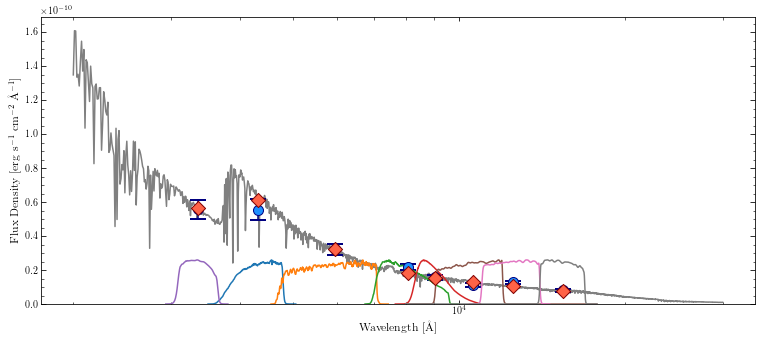

In [8]:
# Generate figure
fig = plt.figure(figsize=(2*6.4,1.1*4.8))
plt.xscale('log')
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux Density [erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]')

# Plot model SED
plt.plot(wl_interp,bestSED,c='grey',zorder=0)

# Plot model photometry
plt.scatter(obsData['wl'], bestPhot, c='tomato', ec='maroon', marker='D', s=100, zorder=3)

# Plot simulated photometry
plt.errorbar(obsData['wl'], obsData['flux'], yerr=obsData['eflux'], fmt='o', mfc='dodgerblue', mec='navy', ecolor='navy', capsize=8, capthick=2, ms=10)

# Plot filter throughput curves
ymin,ymax = bestSED.min(),bestSED.max()
for filt in filtNames:
    filtWl = filtDict[filt][0]
    filtTh = filtDict[filt][1]
    filtTh /= filtTh.max()
    filtTh = 10**(0.2*(np.log10(ymax/ymin))+1)*filtTh * ymin
    plt.plot(filtWl,filtTh)
    
plt.ylim(ymin=0)

plt.show()

Beautiful! Now let's close with some discussion about how this simple exercise compares to what we actually do in practice...

## Closing remarks

The particular method we assumed here was indeed a special, simplified case. In practice, there are five additional key components that should be accounted for when fitting galaxy SEDs:

1. Distance uncertainty
We only know the distances (e.g. through Cepheid variables, Type Ia SNe, etc.) to a _very_ small fraction of the total number of galaxies we've observed. Additionally, the SEDs of most galaxies are cosmologically redshifted towards longer wavelengths. Any research-standard SED-fitting code must account for these cosmological effects by fitting for another free parameter, redshift. 

2. Metallicity
In this exercise, we assumed that the stellar metallicity of our galaxy was equal to that of the Sun. This isn't a horrible assumption for Milky Way type galaxies, but many galaxies can be much more metal-poor or metal-rich, which impacts on their observed SEDs. Most population synthesis models (like BPASS) provide sets of SED templates, like the one we used above, for various stellar metallicities. This adds metallicity, $Z$, as an additional free parameter to your SED-fitting.

3. Dust
The presence of dust in the ISMs of galaxies can have a dramatic effect on their SEDs, absorbing blue starlight and re-emitting it in the far-infrared. Without accounting for dust, you might infer that a galaxy is older than it really is due to the lack of UV light (which mostly stems from young stars)! Prescriptions for dust extinction can be applied to your model SEDs, but this adds yet another free parameter (e.g. dust optical depth) to your fit.

4. Complex star formation histories (SFHs)
By fitting SSP SEDs, we implicitly assumed that all the stars in our galaxy were formed at the same time in an instantaneous burst of star formation (i.e. a delta function star formation history). However, in practice, galaxies undergo star formation over long periods of time, resulting in a global stellar population composed of many SSPs (a composite stellar population) with different metallicities and ages. Many SED-fitting codes allow the user to specify some functional form to this star formation history (e.g., $\mathrm{SFR}(t)\propto t$ or $\mathrm{SFR}(t)\propto te^{-t/\tau}$ where $\tau$ is a free parameter). Recently, attention has been paid to the implementation of non-parametric star formation histories in these codes due to the stochastic nature of star formation observed in real galaxies... There is truly a lot to be said on this subject!

5. Attenuation by the IGM
The light from very distant galaxies will not in general complete their journey through the intergalactic medium unscathed. At higher redshifts, larger amounts of neutral hydrogen exist in the IGM, which serves to absorb far-UV ($\lambda<912$ \AA) photons and resonantly scatter certain hydrogen line photons (e.g. Ly$\alpha$) along the line of sight. Several attenuation models exist for this, which can be applied to your model SEDs when sampling your redshift parameter space.

With the exception of SFHs, each of these points would be relatively straightforward to implement into this code! Essentially, addressing these points would entail adding additional dimensions to your grid of models (in addition to applying dust and IGM prescriptions, which is also fairly straightforward).

To close, it is worth noting that with the addition of these free parameters, a simple least-squared fit may no longer be the best option. Recent SED-fitting codes (e.g. BEAGLE, BAGPIPES, Prospector) have implemented more sophisticated Bayesian sampling routines such as MCMC and nested sampling to efficiently sample the increasingly large parameter space while avoiding getting trapped in local minima in the chi^2 surface.